In [742]:

# !pip install binance 

from binance import Client
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import mplfinance as mpf
import math
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm

# Set figsize of plot
plt.rcParams["figure.figsize"] = (20, 7)

1.GET HISTORICAL DATA

In [743]:
# Get public key and private key from Binance (API Management) 
api_key = "NT1J5dc36vJnNtzoqGK6JuJcJI7oqEYKzYYGsZcswFaYOA5SrxnDWwvaX33qsZmg"
secret ="IqN8nyddAUEcB10V4nzXFTjiEFPsK1PZUvN5C7XZhMJyIBDOPVPxmWuyfKpetLKh"
client = Client(api_key, secret)

#Get data 
historical = client.get_historical_klines("DOTUSDT", Client.KLINE_INTERVAL_1DAY,"1 Jan 2013")
data = pd.DataFrame(historical)

data

,0,1,2,3,4,5,6,7,8,9,10,11
0,1597708800000,2.09000000,4.44000000,2.00000000,3.10000000,6039881.97000000,1597795199999,18375373.39233600,22593,3458952.50000000,10596741.99470400,0
1,1597795200000,3.10000000,3.19990000,2.64000000,2.95000000,15895774.92000000,1597881599999,47558321.63325400,75075,9037381.99000000,27152372.22780000,0
2,1597881600000,2.94490000,3.11110000,2.60000000,2.90000000,11040863.60000000,1597967999999,31457410.86681700,53797,5189595.84000000,14890085.87234500,0
3,1597968000000,2.89780000,3.09000000,2.68260000,2.83300000,9765153.74000000,1598054399999,28393535.85348400,50378,5164025.18000000,15030060.89473700,0
4,1598054400000,2.83870000,4.55000000,2.78200000,4.45460000,41611476.51000000,1598140799999,158038898.76509200,289179,23427260.15000000,88968596.11535300,0
...,...,...,...,...,...,...,...,...,...,...,...,...
520,1642636800000,24.06000000,25.62000000,22.84000000,23.01000000,6578668.82000000,1642723199999,160357989.39780000,278348,3149652.41000000,76921435.15140000,0
521,1642723200000,23.01000000,23.48000000,19.04000000,19.67000000,17269209.91200000,1642809599999,371432669.91895000,599228,7995489.09000000,171989675.87731000,0
522,1642809600000,19.66000000,20.16000000,16.17000000,18.27000000,23239217.06800000,1642895999999,424011444.45833800,629097,11275865.24000000,205839229.79330000,0
523,1642896000000,18.27000000,19.20000000,17.73000000,18.81000000,11483380.21000000,1642982399999,212079989.02780000,338840,5761415.86000000,106440359.56450000,0


2.TRANFORM RAW DATA

In [744]:
#Set index and name for columns
data.columns = ["Open time",'Open','High','Low','Close','Volume','Close time','Quote Asset Volume','Number of trade','tb base volume','tb quote volume','ignore']

#Convert open time and close time columns from num to datatime
data['Open time']= pd.to_datetime(data['Open time']/1000, unit ='s')
data['Close time']= pd.to_datetime(data['Close time']/1000, unit ='s')

#Tranform the others to numeric 
numeric_columns = ['Open','High','Low','Close','Volume','Quote Asset Volume','tb base volume','tb quote volume']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, axis =1)

data

,Open time,Open,High,Low,Close,Volume,Close time,Quote Asset Volume,Number of trade,tb base volume,tb quote volume,ignore
0,2020-08-18,2.0900,4.4400,2.0000,3.1000,6.039882e+06,2020-08-18 23:59:59.999000064,1.837537e+07,22593,3.458952e+06,1.059674e+07,0
1,2020-08-19,3.1000,3.1999,2.6400,2.9500,1.589577e+07,2020-08-19 23:59:59.999000064,4.755832e+07,75075,9.037382e+06,2.715237e+07,0
2,2020-08-20,2.9449,3.1111,2.6000,2.9000,1.104086e+07,2020-08-20 23:59:59.999000064,3.145741e+07,53797,5.189596e+06,1.489009e+07,0
3,2020-08-21,2.8978,3.0900,2.6826,2.8330,9.765154e+06,2020-08-21 23:59:59.999000064,2.839354e+07,50378,5.164025e+06,1.503006e+07,0
4,2020-08-22,2.8387,4.5500,2.7820,4.4546,4.161148e+07,2020-08-22 23:59:59.999000064,1.580389e+08,289179,2.342726e+07,8.896860e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
520,2022-01-20,24.0600,25.6200,22.8400,23.0100,6.578669e+06,2022-01-20 23:59:59.999000064,1.603580e+08,278348,3.149652e+06,7.692144e+07,0
521,2022-01-21,23.0100,23.4800,19.0400,19.6700,1.726921e+07,2022-01-21 23:59:59.999000064,3.714327e+08,599228,7.995489e+06,1.719897e+08,0
522,2022-01-22,19.6600,20.1600,16.1700,18.2700,2.323922e+07,2022-01-22 23:59:59.999000064,4.240114e+08,629097,1.127587e+07,2.058392e+08,0
523,2022-01-23,18.2700,19.2000,17.7300,18.8100,1.148338e+07,2022-01-23 23:59:59.999000064,2.120800e+08,338840,5.761416e+06,1.064404e+08,0


In [745]:
# Remove cols not used 
df = data.iloc[:,[0,4]]
# Set DATE to index 
df.set_index("Open time", inplace = True)
df.index.name = "Date"
df.columns = ["Price"]
df

,Price
Date,
2020-08-18,3.1000
2020-08-19,2.9500
2020-08-20,2.9000
2020-08-21,2.8330
2020-08-22,4.4546
...,...
2022-01-20,23.0100
2022-01-21,19.6700
2022-01-22,18.2700


3. cHECK DATA

In [746]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525 entries, 2020-08-18 to 2022-01-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   525 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB


In [747]:
df.describe()

,Price
count,525.000000
mean,22.580615
std,13.730458
min,2.833000
25%,6.271800
50%,23.868000
75%,34.130000
max,53.820000


4.ROLLING MEAN AND STANDARD DEVIATION

<AxesSubplot:xlabel='Date'>

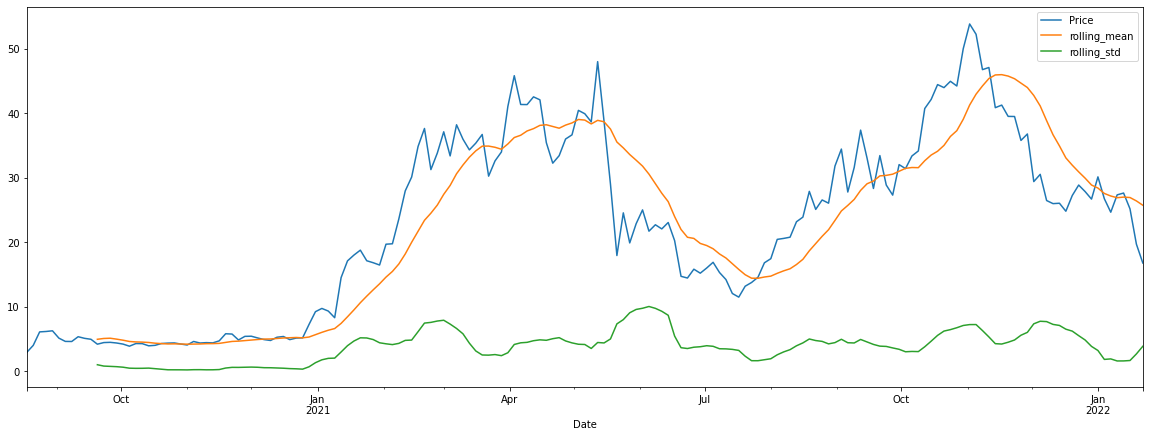

In [748]:
# Rolling mean and std regard 3 days
df_check = df.resample("3D").last()

window_size = 12 
df_check["rolling_mean"] = df_check["Price"].rolling(window = window_size).mean()
df_check["rolling_std"] = df_check["Price"].rolling(window = window_size).std()

df_check.plot()

5. DECOMPOSE TIME SERIES DATA

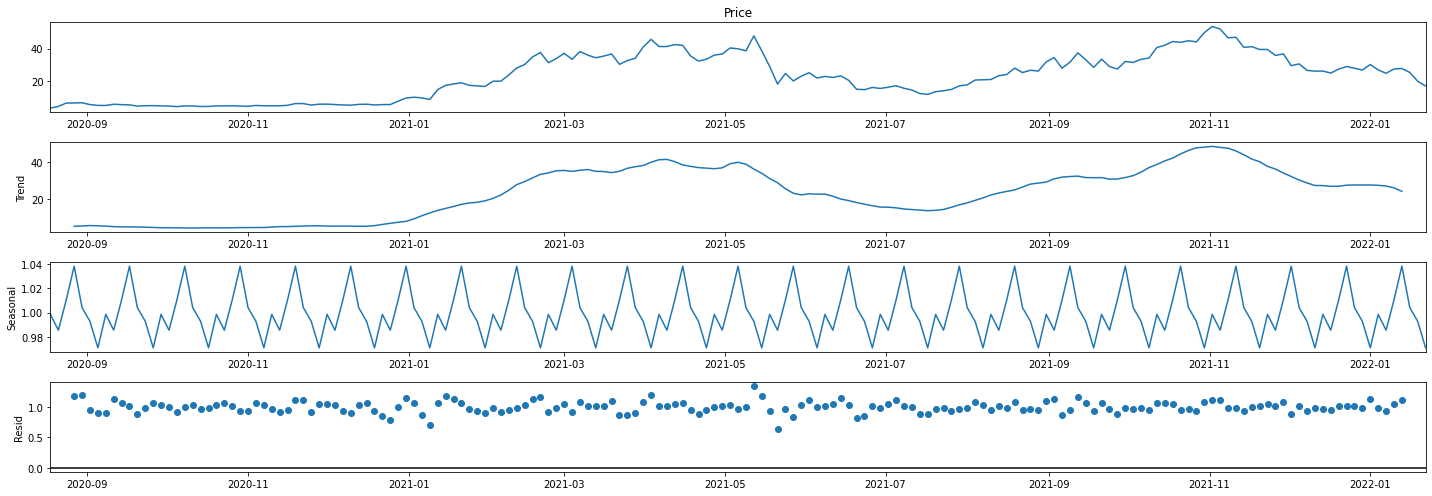

In [749]:
# Decompose data to check seasonal by using multiplicative model 
decompose_results = seasonal_decompose(df_check["Price"], model = "multiplicative") #addictive
decompose_results.plot()
plt.tight_layout()
plt.show()

6. DIFF DATA

<AxesSubplot:title={'center':'Sai phan bac 1'}, xlabel='Date'>

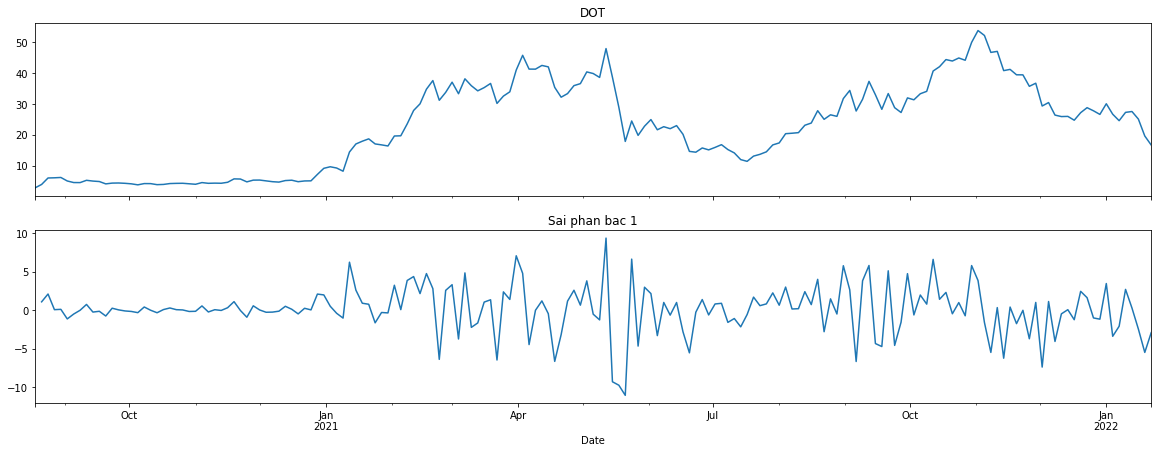

In [750]:
# Sai phan du lieu bac 1

df_diff = df_check.diff(1)
df_diff.dropna(inplace =True)
fig, ax = plt.subplots(2, sharex =True)
df_check["Price"].plot(ax =ax[0], title ="DOT")
df_check['Price'].diff().plot(ax= ax[1], title ="Sai phan bac 1")

In [751]:
df_diff

,Price,rolling_mean,rolling_std
Date,,,
2020-09-23,0.2514,0.126158,-0.209529
2020-09-26,0.0362,0.039350,-0.049349
2020-09-29,-0.1033,-0.143667,-0.043183
2020-10-02,-0.1698,-0.163025,-0.081752
2020-10-05,-0.3253,-0.198942,-0.152117
...,...,...,...
2022-01-10,2.6900,-0.265000,-0.319189
2022-01-13,0.2800,0.096667,0.006348
2022-01-16,-2.4500,-0.067500,0.063781


7.CHECK CORRELATION

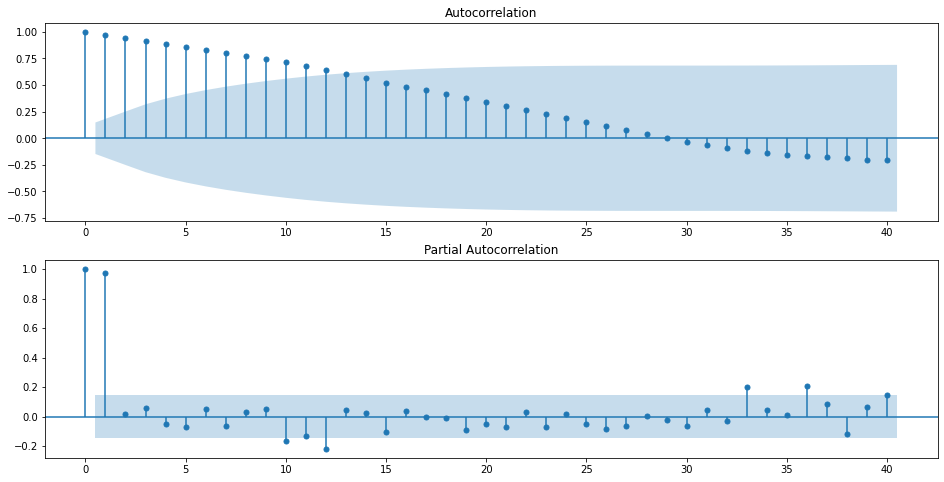

In [752]:

def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''
    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig


# using function test_autocorrelation to check autocorrelation
fig = test_autocorrelation(df_check["Price"])

9.TEST ADF & KPSS

In [753]:
# Ham Kiem dinh ADF
def adf_test(x):
    indices = ["Test Statistics", "p-value", 
                "# of Lags Used","of Observations Used"]
    adf_test = adfuller(x)
    results = pd.Series(adf_test[0:4], index = indices)
    for key, value in adf_test[4].items():
        results[f"Critical Value ({key})"] = value
    return results

# Ham Kiem dinh KPSS
def kpss_test(x):
    indices = ["Test Statistics", "p-value", 
                "# of Lags"]
    kpss_test = kpss(x)
    results = pd.Series(kpss_test[0:3], index = indices)
    for key, value in kpss_test[3].items():
        results[f"Critical Value ({key})"] = value
    return results


#Kiem dinh ADF sai phan bac 1
print(f"Kiem dinh ADF:\n{adf_test(df_diff['Price'])}")

print("--------------------------------------")

#Kiem dinh KPSS sai phan bac 1
print(f"Kiem dinh KPSS:\n{kpss_test(df_diff['Price'])}")


Kiem dinh ADF:
Test Statistics        -1.279757e+01
p-value                 6.863527e-24
# of Lags Used          0.000000e+00
of Observations Used    1.620000e+02
Critical Value (1%)    -3.471374e+00
Critical Value (5%)    -2.879552e+00
Critical Value (10%)   -2.576373e+00
dtype: float64
--------------------------------------
Kiem dinh KPSS:
Test Statistics           0.1695
p-value                   0.1000
# of Lags                14.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
dtype: float64


10.SPLIT DATA AND CHOOSE p d q

In [754]:

# Train & test split
to_row = int(len(df)*0.9)

train =list(df[0:to_row]["Price"])
test =list(df[to_row:]["Price"])


# Using autoarima to choose p d q with AIC smallest

import pmdarima as pm 
auto_arima = pm.auto_arima(df[0:to_row]["Price"], trace =1, 
                            error_action ="ignore",
                            suppress_warnings =True, 
                            seasonal = False, 
                            stepwise =True, 
                            approximation =False, 
                            n_jobs =-1, 
                            seasonal_test =None)




Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1923.570, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1926.375, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1923.816, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1924.184, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1925.027, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1927.026, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1921.877, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1919.878, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1925.153, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1925.078, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1918.613, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1922.983, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1922.614, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1920.613, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [755]:

# Using plotly.express
import plotly.graph_objects as go
import plotly.express as px


# Visualization
fig = go.Figure()
fig.add_trace(go.Scatter(x= df[0:to_row]["Price"].index, y= df[0:to_row]["Price"],
                    mode='lines+markers',
                    name='Train data'))
fig.add_trace(go.Scatter(x=df[to_row:]["Price"].index, y=df[to_row:]["Price"],
                    mode='lines+markers',
                    name='Test data'))
# Edit the layout
fig.update_layout(title='DOT ACTUAL PRICES', title_x =0.5,
                   xaxis_title='Date',
                   yaxis_title='CLOSING PRICES')

fig.show()

11.BUILD MODEL PREDICT

In [757]:
# Build model prediction

model_predictions = []
test_obser = len(test)

for i in range(test_obser):
    model = sm.tsa.arima.ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    model_predictions.append(output[0])
    train.append(test[i])
    

In [758]:
#Print summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  524
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1057.584
Date:                Tue, 25 Jan 2022   AIC                           2121.168
Time:                        00:16:26   BIC                           2133.946
Sample:                             0   HQIC                          2126.172
                                - 524                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8484      0.094     -9.064      0.000      -1.032      -0.665
ma.L1          0.7805      0.107      7.269      0.000       0.570       0.991
sigma2         3.3413      0.089     37.732      0.0

In [759]:
# Visualization
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[to_row:]["Price"].index, y= model_predictions,
                    mode='lines+markers',
                    name='prices predicted data'))
fig.add_trace(go.Scatter(x=df[to_row:]["Price"].index, y=df[to_row:]["Price"],
                    mode='lines+markers',
                    name='Test data'))
# fig.add_trace(go.Scatter(x=df[to_row:]["Close"].index, y=df[to_row:]["Close"],
#                     mode='lines+markers',
#                     name='Test data'))
# Edit the layout
fig.update_layout(title='DOT ACTUAL PRICES vs Prices Predicted', title_x =0.5,
                   xaxis_title='Date',
                   yaxis_title='PRICES')

fig.show()

12.EVALUATE MODEL BY MAPE

In [760]:
#Evaluate model

mape = np.mean(np.abs((np.array(model_predictions) - np.array(test))/np.abs(test)))
print("MAPE:"+ str(mape))

MAPE:0.05391257179540348


13. RESIDUALS TEST

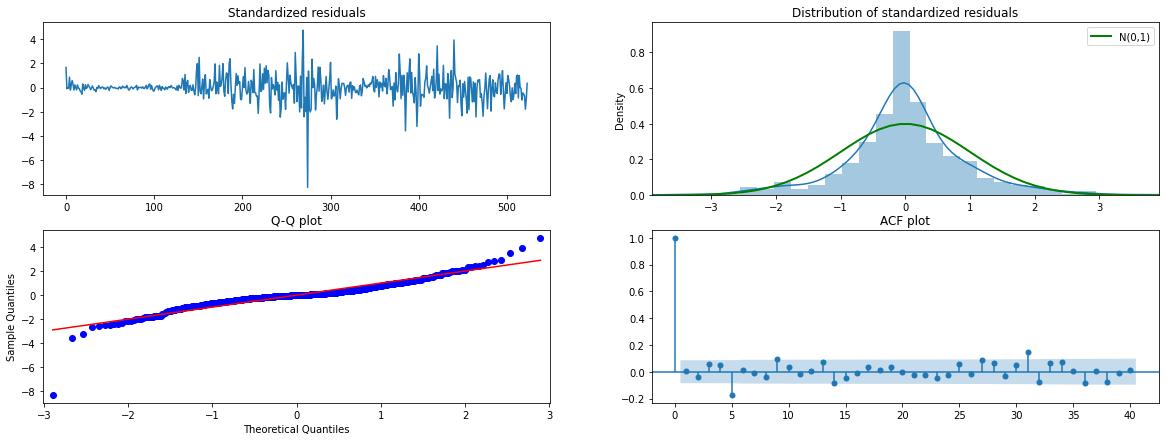

In [761]:
# Kiêm dinh độ tin cậy bằng phân tích phần dư
def arima_diagnostics(resids, n_lags=40):
 # create placeholder subplots
 fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
 r = resids
 resids = (r - np.nanmean(r)) / np.nanstd(r)
 resids_nonmissing = resids[~(np.isnan(resids))]
 # residuals over time
 sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
 ax1.set_title('Standardized residuals')
 # distribution of residuals
 x_lim = (-1.96 * 2, 1.96 * 2)
 r_range = np.linspace(x_lim[0], x_lim[1])
 norm_pdf = scs.norm.pdf(r_range)
 sns.distplot(resids_nonmissing, hist=True, kde=True,
 norm_hist=True, ax=ax2)
 ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
 ax2.set_title('Distribution of standardized residuals')
 ax2.set_xlim(x_lim)
 ax2.legend()
 # Q-Q plot
 qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
 ax3.set_title('Q-Q plot')
# ACF plot
 plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
 ax4.set_title('ACF plot')
 return plt.show()
 

arima_diagnostics(model_fit.resid,40)